In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image

# sklearn utilities
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# sklearn models
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

In [2]:
# Adds images to array
images = np.zeros((2000, 250, 250, 3)) # I changed this to be the actual dimensions that np.asarray will copy into
j = 0
for i in range(1522): # Our ranges were off by 1 so I fixed that
  try:
    image_name = 'F_' + str(i) + '.jpg'
    path = "Fire/" + image_name
    image = (Image.open(path))
    img = np.asarray(image)
    images[j] = np.copy(img)
    j = j+1
  except:
    continue

In [3]:
for i in range(1011): # Range was off by 1 like above
  try:
    image_name = 'NF_' + str(i) + '.jpg'
    path = 'Non_Fire/' + image_name
    image = (Image.open(path))
    img = np.asarray(image)
    images[j] = np.copy(img)
    j = j+1
  except:
    continue

In [4]:
targets = np.zeros(2000)
for i in range(1000):
  targets[i] = 1

In [5]:
images_flat = images.reshape((2000, 187500))
images_norm = normalize(images_flat)

In [6]:
pca = PCA(10)
transformed_data = pca.fit_transform(images_norm)

# Split data and plot scatter plot
# plot_x, plot_y = np.hsplit(transformed_data, 2)
# scatter = plt.scatter(plot_x, plot_y, c=targets)
# plt.legend(*scatter.legend_elements(), loc='upper left')

In [8]:
# For genuine results don't set a random_state
x_train, x_test, y_train, y_test = train_test_split(transformed_data, targets, test_size=.25)
x_train_cnn, x_test_cnn, y_train_cnn, y_test_cnn = train_test_split(images_norm, targets, test_size=.25)

In [ ]:
# Confirm shape of data and targets
print("Training x:", x_train.shape,"y:", y_train.shape)
print("Testing x:", x_test.shape,"y:", y_test.shape)

In [ ]:
logreg_model = LogisticRegression()

# cv_logreg_results = cross_validate(logreg_model, x_train, y_train, cv=10)
# print(sorted(cv_logreg_results.keys()))
# print(cv_logreg_results['test_score'])

logreg_model.fit(x_train, y_train)
logreg_results = logreg_model.predict(x_test)

In [ ]:
logreg_conf_matrix = confusion_matrix(y_test, logreg_results)
pd.DataFrame(logreg_conf_matrix, columns=[0, 1], index=[0,1])

In [ ]:
print(classification_report(y_test, logreg_results))

In [ ]:
svm_model = SVC(kernel='rbf')
svm_model.fit(x_train, y_train)
svm_results = svm_model.predict(x_test)

In [ ]:
svm_conf_matrix = confusion_matrix(y_test, svm_results)
pd.DataFrame(svm_conf_matrix, columns=[0, 1], index=[0,1])

In [ ]:
print(classification_report(y_test, svm_results))

# Below here is using DataFrame and Convolutional Neural Network (CNN)

In [70]:
x_train_cnn = np.reshape(x_train_cnn, (1500, 250, 250, 3))
y_train_cnn = np.reshape(y_train_cnn, (1500, 1))
x_test_cnn = np.reshape(x_test_cnn, (500, 250, 250, 3))
y_test_cnn = np.reshape(y_test_cnn, (500, 1))

In [71]:
xtrain, xval, ytrain, yval = train_test_split(x_train, y_train, test_size=0.20)
print(xtrain.shape)
print(ytrain.shape)
print(xval.shape)
print(yval.shape)

(1200, 250, 250, 3)
(1200, 1)
(300, 250, 250, 3)
(300, 1)


In [72]:
model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(250, 250, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2))

In [73]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_31 (Conv2D)                   │ (None, 248, 248, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 124, 124, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 122, 122, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 61, 61, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 59, 59, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 57, 57, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 103968)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 32)                  │       3,327,008 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,350,658 (12.78 MB)

 Trainable params: 3,350,658 (12.78 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(xtrain, ytrain, epochs=15, validation_data=(xval, yval))

Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 17s 314ms/step - accuracy: 0.5815 - loss: 0.6765 - val_accuracy: 0.6233 - val_loss: 0.5987
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 290ms/step - accuracy: 0.7537 - loss: 0.5061 - val_accuracy: 0.8167 - val_loss: 0.3830
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 288ms/step - accuracy: 0.7067 - loss: 0.5592 - val_accuracy: 0.6133 - val_loss: 0.9562
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 288ms/step - accuracy: 0.7713 - loss: 0.5204 - val_accuracy: 0.8133 - val_loss: 0.3851
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 288ms/step - accuracy: 0.8133 - loss: 0.4192 - val_accuracy: 0.8767 - val_loss: 0.2952
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 287ms/step - accuracy: 0.8474 - loss: 0.3762 - val_accuracy: 0.8767 - val_loss: 0.2956
Epoch 7/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 282ms/step - accuracy: 0.8519 - loss: 0.3364 - val_accuracy: 0.8133 - val_loss: 0.4069
Epoch 8/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 11s 287ms/step - accuracy: 0.8509 - loss: 0.3353 - val_accu

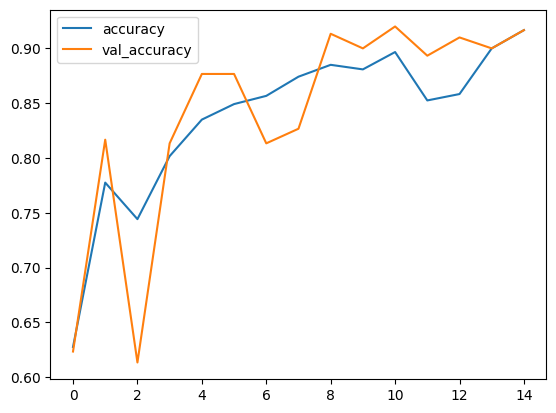

In [75]:
plt.plot(history.history['accuracy'], label="accuracy")
plt.plot(history.history['val_accuracy'], label="val_accuracy")
plt.legend()
plt.show()

In [76]:
model.evaluate(x_test, y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.9251 - loss: 0.1983


[0.20834173262119293, 0.9160000085830688]